In [1]:
import pandas as pd
import numpy as np
import gc
import importlib

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import VarianceThreshold

In [4]:
app_train = pd.read_csv("app_train_new.csv").reset_index(drop = True)
app_test = pd.read_csv("app_test_new.csv").reset_index(drop = True)
app_train = app_train.drop("Unnamed: 0", axis=1)
app_test = app_test.drop("Unnamed: 0", axis=1)

In [12]:
app_train["TARGET"].value_counts()

False    282686
True      24825
Name: TARGET, dtype: int64

NAME_INCOME_TYPE_Pensioner and ORGANIZATION_TYPE_XNA: 0.9996475770944251
NAME_INCOME_TYPE_Pensioner和ORGANIZATION_TYPE_XNA高度相关

OBS_30_CNT_SOCIAL_CIRCLE and OBS_60_CNT_SOCIAL_CIRCLE: 0.9984895425113564
OBS_30_CNT_SOCIAL_CIRCLE和OBS_60_CNT_SOCIAL_CIRCLE高度相关

In [3]:
def kde_target(var_name, df):
    
    # Calculate the correlation coefficient between the new variable and the target
    corr = df['TARGET'].corr(df[var_name])
    
    # Calculate medians for repaid vs not repaid
    avg_repaid = df.ix[df['TARGET'] == 0, var_name].median()
    avg_not_repaid = df.ix[df['TARGET'] == 1, var_name].median()
    
    plt.figure(figsize = (12, 6))
    
    # Plot the distribution for target == 0 and target == 1
    display(df[df['TARGET'] == 0][var_name])
    sns.kdeplot(df.ix[df['TARGET'] == 0, var_name].dropna(), label = 'TARGET == 0')
    sns.kdeplot(df.ix[df['TARGET'] == 1, var_name].dropna(), label = 'TARGET == 1')
    
    # label the plot
    plt.xlabel(var_name); plt.ylabel('Density'); plt.title('%s Distribution' % var_name)
    plt.legend();
    
    # print out the correlation
    print('The correlation between %s and the TARGET is %0.4f' % (var_name, corr))
    # Print out average values
    print('Median value for loan that was not repaid = %0.4f' % avg_not_repaid)
    print('Median value for loan that was repaid =     %0.4f' % avg_repaid)

count    306490.000000
mean          0.016953
std           0.133079
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           4.000000
Name: OBS_30_60_rate, dtype: float64

c:\users\yyq\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  import sys
c:\users\yyq\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  
c:\users\yyq\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  del sys.path[0]
c:

The correlation between OBS_30_60_rate and the TARGET is 0.0034
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


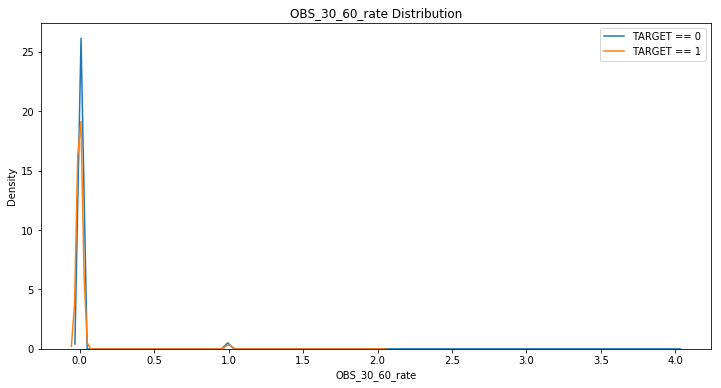

In [25]:
app_train["OBS_30_60_rate"] = (app_train["OBS_30_CNT_SOCIAL_CIRCLE"]-app_train["OBS_60_CNT_SOCIAL_CIRCLE"])
# app_train["OBS_30_60_rate"] = app_train["OBS_30_60_rate"].replace(np.inf, np.nan)
display(app_train["OBS_30_60_rate"].describe())
kde_target("OBS_30_60_rate", app_train)
app_train = app_train.drop(["OBS_30_60_rate"], axis=1)

In [11]:
app_train[app_train["ORGANIZATION_TYPE_XNA"]!=app_train["NAME_INCOME_TYPE_Pensioner"]]["TARGET"].value_counts()

False    24
True      8
Name: TARGET, dtype: int64

In [15]:
app_train[(app_train["ORGANIZATION_TYPE_XNA"]==1) & (app_train["NAME_INCOME_TYPE_Pensioner"]==0)]["TARGET"].value_counts()

False    14
True      8
Name: TARGET, dtype: int64

In [16]:
app_train[app_train["ORGANIZATION_TYPE_XNA"]==1]["TARGET"].value_counts()

False    52384
True      2990
Name: TARGET, dtype: int64

似乎不属于任何机构又不领退休金的人很容易违约

In [13]:
app_train[app_train["ORGANIZATION_TYPE_XNA"]!=app_train["NAME_INCOME_TYPE_Pensioner"]][["ORGANIZATION_TYPE_XNA", "NAME_INCOME_TYPE_Pensioner"]]

,ORGANIZATION_TYPE_XNA,NAME_INCOME_TYPE_Pensioner
1156,1,0
3937,1,0
18196,0,1
23834,1,0
33165,0,1
35352,1,0
37512,1,0
41723,1,0
77179,1,0
78336,1,0


In [2]:
def load_extra_features(app_train, app_test, *tables):
    for df in [app_train, app_test]:
        df['NEW_CREDIT_TO_ANNUITY_RATIO'] = df['AMT_CREDIT'] / df['AMT_ANNUITY']
        df['NEW_EXT_SOURCES_MEAN'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
        df['NEW_CREDIT_TO_GOODS_RATIO'] = df['AMT_CREDIT'] / df['AMT_GOODS_PRICE']
        df['NEW_CAR_TO_BIRTH_RATIO'] = df['OWN_CAR_AGE'] / df['DAYS_BIRTH']
        df['NEW_CAR_TO_EMPLOY_RATIO'] = df['OWN_CAR_AGE'] / df['DAYS_EMPLOYED']
        df['NEW_PHONE_TO_BIRTH_RATIO'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_BIRTH']
        df['NEW_PHONE_TO_EMPLOY_RATIO'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_EMPLOYED']
        df['NEW_CREDIT_TO_INCOME_RATIO'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']
        df['WORKING_LIFE_RATIO'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
        df['INCOME_PER_FAM'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
        df['CHILDREN_RATIO'] = df['CNT_CHILDREN'] / df['CNT_FAM_MEMBERS']
        
        df["OBS_30_60_diff"] = (df["OBS_30_CNT_SOCIAL_CIRCLE"]-df["OBS_60_CNT_SOCIAL_CIRCLE"])
        
    for table in tables:
        app_train = app_train.merge(right=table.reset_index(), how='left', on='SK_ID_CURR')
        app_test = app_test.merge(right=table.reset_index(), how='left', on='SK_ID_CURR')
    return app_train, app_test


In [2]:
def load_dataframe(loc):
    df = pd.read_csv(loc).reset_index(drop = True)
    if "Unnamed: 0" in df.columns:
        df = df.drop("Unnamed: 0", axis=1)
    return df

In [26]:
bureau = pd.read_csv("bureau_new.csv").reset_index(drop = True)
bureau = bureau.drop("Unnamed: 0", axis=1)
bureau[["DAYS_CREDIT", "DAYS_CREDIT_ENDDATE"]]

,DAYS_CREDIT,DAYS_CREDIT_ENDDATE
0,-497,-153.0
1,-208,1075.0
2,-203,528.0
3,-203,NaN
4,-629,1197.0
5,-273,27460.0
6,-43,79.0
7,-1896,-1684.0
8,-1146,-811.0
9,-1146,-484.0


In [3]:
def load_bureau(bureau, buro_balance):
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    bb_cat = [col for col in buro_balance.columns if len(buro_balance[col].unique()) == 2]
    bb_aggregations.update({col: ["mean"] for col in bb_cat})
    buro_balance_agg = buro_balance.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    buro_balance_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in buro_balance_agg.columns.tolist()])
    bureau = bureau.join(buro_balance_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace=True)
    del buro_balance_agg
    gc.collect()
    
    bureau['STATUS_12345'] = 0
    for i in range(1,6):
        bureau['STATUS_12345'] += bureau['STATUS_{}'.format(i)]
    
    bureau["DAYS_CREDIT_ITERVAL"] = bureau["DAYS_CREDIT"] - bureau["DAYS_CREDIT_ENDDATE"]
    bureau["CREDIT_SUM_DEBT_RATIO"] = bureau["AMT_CREDIT_SUM_DEBT"] / bureau["AMT_CREDIT_SUM"]
    bureau["CREDIT_SUM_OVERDUE_RATIO"] = bureau["AMT_CREDIT_SUM_OVERDUE"] / bureau["AMT_CREDIT_SUM"]
    bureau["CREDIT_SUM_LIMIT_DEBT_RATIO"] = bureau["AMT_CREDIT_SUM_DEBT"] / bureau["AMT_CREDIT_SUM_LIMIT"]
    bureau["CREDIT_SUM_LIMIT_OVERDUE_RATIO"] = bureau["AMT_CREDIT_SUM_OVERDUE"] / bureau["AMT_CREDIT_SUM_LIMIT"]
    bureau["ANNUITY_DEBT_RATIO"] = bureau["AMT_CREDIT_SUM_DEBT"] / bureau["AMT_ANNUITY"]
    bureau["ANNUITY_OVERDUE_RATIO"] = bureau["AMT_CREDIT_SUM_OVERDUE"] / bureau["AMT_ANNUITY"]
    bureau["MAX_OVERDUE_RATIO"] = bureau["AMT_CREDIT_SUM_OVERDUE"] / bureau["AMT_CREDIT_MAX_OVERDUE"]
    
    bureau['ENDDATE_DIF'] = bureau['DAYS_CREDIT_ENDDATE'] - bureau['DAYS_ENDDATE_FACT']
    bureau['DEBT_CREDIT_DIFF'] = bureau['AMT_CREDIT_SUM'] - bureau['AMT_CREDIT_SUM_DEBT']
    num_aggregations = {
        'STATUS_0': ['mean'],
        'STATUS_1': ['mean'],
        'STATUS_12345': ['mean'],
        'STATUS_C': ['mean'],
        'STATUS_X': ['mean'],
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum'],
        
        "DAYS_CREDIT_ITERVAL": ['min', 'max', 'mean', 'var'],
        "CREDIT_SUM_DEBT_RATIO": ['min', 'max', 'mean', 'var'],
        "CREDIT_SUM_OVERDUE_RATIO": ['min', 'max', 'mean', 'var'],
        "CREDIT_SUM_LIMIT_DEBT_RATIO": ['min', 'max', 'mean', 'var'],
        "CREDIT_SUM_LIMIT_OVERDUE_RATIO": ['min', 'max', 'mean', 'var'],
        "ANNUITY_DEBT_RATIO": ['min', 'max', 'mean', 'var'],
        "ANNUITY_OVERDUE_RATIO": ['min', 'max', 'mean', 'var'],
        "MAX_OVERDUE_RATIO": ['min', 'max', 'mean', 'var'],
        'DEBT_CREDIT_DIFF': ['mean', 'sum'],
        'ENDDATE_DIF': ['mean', 'sum', "max"],
    }
    cat_aggregations = {col: ["mean"] for col in bureau.columns if len(bureau[col].unique()) == 2}
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    
    BUREAU_ACTIVE_AGG = {
    'DAYS_CREDIT': ['max', 'mean'],
    'DAYS_CREDIT_ENDDATE': ['min', 'max'],
    'AMT_CREDIT_MAX_OVERDUE': ['max', 'mean'],
    'AMT_CREDIT_SUM': ['max', 'sum'],
    'AMT_CREDIT_SUM_DEBT': ['mean', 'sum'],
    'AMT_CREDIT_SUM_OVERDUE': ['max', 'mean'],
    'DAYS_CREDIT_UPDATE': ['min', 'mean'],
    'DEBT_PERCENTAGE': ['mean'],
    'DEBT_CREDIT_DIFF': ['mean'],
    'CREDIT_TO_ANNUITY_RATIO': ['mean'],
    'MONTHS_BALANCE_MEAN': ['mean', 'var'],
    'MONTHS_BALANCE_SIZE': ['mean', 'sum'],
    }

    BUREAU_CLOSED_AGG = {
    'DAYS_CREDIT': ['max', 'var'],
    'DAYS_CREDIT_ENDDATE': ['max'],
    'AMT_CREDIT_MAX_OVERDUE': ['max', 'mean'],
    'AMT_CREDIT_SUM_OVERDUE': ['mean'],
    'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_DEBT': ['max', 'sum'],
    'DAYS_CREDIT_UPDATE': ['max'],
    'ENDDATE_DIF': ['mean'],
    'STATUS_12345': ['mean'],
    }
    
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(BUREAU_ACTIVE_AGG)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(BUREAU_CLOSED_AGG)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg
    gc.collect()
    return bureau_agg

In [4]:
prev = pd.read_csv("previous_new.csv").reset_index(drop = True)
prev = prev.drop("Unnamed: 0", axis=1)

prev.shape

(1670214, 163)

In [4]:
def load_prev(prev):
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    prev["APP_DURATION"] =  prev["DAYS_TERMINATION"] - prev["DAYS_DECISION"]
    prev["APP_PAY_DURATION"] = prev["DAYS_LAST_DUE"] - prev["DAYS_FIRST_DRAWING"]
    prev["INTREST_RATE_RATIO"] = prev["RATE_INTEREST_PRIVILEGED"]/prev["RATE_INTEREST_PRIMARY"]
    prev['CREDIT_TO_GOODS_RATIO'] = prev['AMT_CREDIT'] / prev['AMT_GOODS_PRICE']
    
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
        
        "APP_DURATION": ['max', 'mean', 'sum'],
        "APP_PAY_DURATION": ['max', 'mean', 'sum'],
        "INTREST_RATE_RATIO": ['max', 'mean', 'sum', 'var'],
        'CREDIT_TO_GOODS_RATIO': ['max', 'mean', 'sum', 'var'],
    }
    cat_aggregations = {col: ["mean"] for col in prev.columns if len(prev[col].unique()) == 2}
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
#     print(prev_agg.columns.tolist())
#     prev_agg = prev_agg.join(prev_agg, how='left', on='SK_ID_CURR')

    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    del approved, approved_agg
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg
    gc.collect()
    return prev_agg

In [5]:
inst = pd.read_csv("installments_new.csv").reset_index(drop = True)
inst = inst.drop("Unnamed: 0", axis=1)

inst.shape

(13605401, 8)

In [16]:
prev[["DAYS_DECISION", 'DAYS_LAST_DUE', "DAYS_FIRST_DRAWING", "DAYS_TERMINATION", "RATE_INTEREST_PRIMARY", "RATE_INTEREST_PRIVILEGED"]][50:100]

,DAYS_DECISION,DAYS_LAST_DUE,DAYS_FIRST_DRAWING,DAYS_TERMINATION,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED
50,-161,NaN,NaN,NaN,NaN,NaN
51,-766,-466.0,365243.0,-464.0,NaN,NaN
52,-774,NaN,NaN,NaN,NaN,NaN
53,-598,-357.0,365243.0,-344.0,NaN,NaN
54,-409,NaN,NaN,NaN,NaN,NaN
55,-557,-197.0,365243.0,-194.0,NaN,NaN
56,-1042,-742.0,365243.0,-738.0,NaN,NaN
57,-209,NaN,NaN,NaN,NaN,NaN
58,-183,-3.0,365243.0,NaN,NaN,NaN
59,-1773,-1472.0,365243.0,-1464.0,NaN,NaN


In [5]:

def load_install(inst):
    inst["DPD"] = inst['DAYS_ENTRY_PAYMENT'] - inst['DAYS_INSTALMENT']
    inst["DBD"] = inst['DAYS_INSTALMENT'] - inst['DAYS_ENTRY_PAYMENT']
    inst['DPD'] = inst['DPD'].apply(lambda x: x if x > 0 else 0)
    inst['DBD'] = inst['DBD'].apply(lambda x: x if x > 0 else 0)
    inst['PAYMENT_PERC'] = inst['AMT_PAYMENT'] / inst['AMT_INSTALMENT']
    inst['PAYMENT_DIFF'] = inst['AMT_INSTALMENT'] - inst['AMT_PAYMENT']
    
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
    }
    aggregations.update({col: ["mean"] for col in inst.columns if len(inst[col].unique()) == 2})
    inst_agg = inst.groupby('SK_ID_CURR').agg(aggregations)
#     print(inst_agg.columns)
    inst_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in inst_agg.columns.tolist()])
    inst_agg["INSTAL_TOTAL_PAYMENT_RATE"] = inst_agg["INSTAL_AMT_PAYMENT_SUM"]/inst_agg["INSTAL_AMT_INSTALMENT_SUM"]
    inst_agg['INSTAL_COUNT'] = inst.groupby('SK_ID_CURR').size()
#     del inst
#     gc.collect()
    return inst_agg

In [6]:
def load_cash(cash):
    cash["INSTALMENT_FUTURE_RATIO"] = cash["CNT_INSTALMENT_FUTURE"] / cash["CNT_INSTALMENT"]
    cash["INSTALMENT_BALANCE_RATIO"] = cash["CNT_INSTALMENT_FUTURE"] / cash["MONTHS_BALANCE"].abs()
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean'],
        "CNT_INSTALMENT": ['max', 'mean', 'sum', 'var'],
        "CNT_INSTALMENT_FUTURE": ['max', 'mean', 'sum', 'var'],
        
        "INSTALMENT_FUTURE_RATIO": ['max', 'mean', 'sum', 'var'],
        "INSTALMENT_BALANCE_RATIO": ['max', 'mean', 'sum', 'var'],
    }
    aggregations.update({col: ["mean"] for col in cash.columns if len(cash[col].unique()) == 2})
    cash_agg = cash.groupby('SK_ID_CURR').agg(aggregations)
    cash_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in cash_agg.columns.tolist()])
    # Count pos cash accounts
    cash_agg['POS_COUNT'] = cash.groupby('SK_ID_CURR').size()
    return cash_agg

In [7]:
def load_credit(credit):
    credit["INSTALMENT_MATURE_BALANCE_RATIO"] = credit["CNT_INSTALMENT_MATURE_CUM"] / credit["MONTHS_BALANCE"].abs()
    credit["POS_AMT_MEAN"] = credit["AMT_DRAWINGS_POS_CURRENT"] / credit["CNT_DRAWINGS_POS_CURRENT"]
    credit["PAYMENT_DIFF"] = credit["AMT_PAYMENT_CURRENT"] - credit["AMT_PAYMENT_TOTAL_CURRENT"]
    credit["RECEIVABLE_DIFF"] = credit["AMT_TOTAL_RECEIVABLE"] - credit["AMT_RECIVABLE"]
    credit["RECEIVABLE_PRINCIPAL_DIFF"] = credit["AMT_TOTAL_RECEIVABLE"] - credit["AMT_RECEIVABLE_PRINCIPAL"]

    for col in ["CNT_DRAWINGS_ATM_CURRENT", "CNT_DRAWINGS_OTHER_CURRENT", "CNT_DRAWINGS_POS_CURRENT"]:
        credit["RELATIVE" + col[col.find("_"):]] = credit[col] / credit["CNT_DRAWINGS_CURRENT"]
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', "min", 'size'],
        'AMT_BALANCE': ['max', 'mean', 'sum', 'var'],
        'AMT_CREDIT_LIMIT_ACTUAL': ['max', 'mean', 'sum', 'var'],
        "AMT_DRAWINGS_ATM_CURRENT": ['max', 'mean', 'sum', 'var'],
        "AMT_DRAWINGS_CURRENT": ['max', 'mean', 'sum', 'var'],
        "AMT_DRAWINGS_OTHER_CURRENT": ['max', 'mean', 'sum', 'var'],
        "AMT_DRAWINGS_POS_CURRENT": ['max', 'mean', 'sum', 'var'],
        "AMT_INST_MIN_REGULARITY": ['max', 'mean', 'sum', 'var'],
        "AMT_PAYMENT_CURRENT": ['max', 'mean', 'sum', 'var'],
        "AMT_PAYMENT_TOTAL_CURRENT": ['max', 'mean', 'sum', 'var'],
        "AMT_RECEIVABLE_PRINCIPAL": ['max', 'mean', 'sum', 'var'],
        "AMT_RECIVABLE": ['max', 'mean', 'sum', 'var'],
        "AMT_TOTAL_RECEIVABLE": ['max', 'mean', 'sum', 'var'],
        "CNT_DRAWINGS_ATM_CURRENT": ['max', 'mean', 'sum', 'var'],
        "CNT_DRAWINGS_CURRENT": ['max', 'mean', 'sum', 'var'],
        "CNT_DRAWINGS_OTHER_CURRENT": ['max', 'mean', 'sum', 'var'],
        "CNT_DRAWINGS_POS_CURRENT": ['max', 'mean', 'sum', 'var'],
        "CNT_INSTALMENT_MATURE_CUM": ['max', 'mean', 'sum', 'var'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean'],
        
        "INSTALMENT_MATURE_BALANCE_RATIO": ['max', 'mean', 'sum', 'var'],
        "POS_AMT_MEAN": ['max', 'mean', 'sum', 'var'],
        "PAYMENT_DIFF": ['max', 'mean', 'sum', 'var'],
        "RECEIVABLE_DIFF": ['max', 'mean', 'sum', 'var'],
        "RECEIVABLE_PRINCIPAL_DIFF": ['max', 'mean', 'sum', 'var'],
    }
    aggregations.update({"RELATIVE" + col[col.find("_"):]: ['max', 'mean', 'sum', 'var'] for col in ["CNT_DRAWINGS_ATM_CURRENT", "CNT_DRAWINGS_OTHER_CURRENT", "CNT_DRAWINGS_POS_CURRENT"]})
    aggregations.update({col: ["mean"] for col in credit.columns if len(credit[col].unique()) == 2})
    cc_agg = credit.groupby('SK_ID_CURR').agg(aggregations)
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = credit.groupby('SK_ID_CURR').size()
    return cc_agg

In [3]:
cc = pd.read_csv("credit_new.csv").reset_index(drop = True)
cc = cc.drop("Unnamed: 0", axis=1)
# cash = pd.read_csv("cash_new.csv").reset_index(drop = True)
# cash = cash.drop("Unnamed: 0", axis=1)
# cb = cash[:5000].merge(right=cc[:5000].reset_index(), how='left', on='SK_ID_CURR')

In [4]:
cc[["AMT_PAYMENT_CURRENT", "AMT_PAYMENT_TOTAL_CURRENT", "AMT_RECEIVABLE_PRINCIPAL", "AMT_RECIVABLE", "AMT_TOTAL_RECEIVABLE"]]

,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE
0,1800.000000,1800.000000,0.000000,0.000000,0.000000
1,2250.000000,2250.000000,60175.078125,64875.554688,64875.554688
2,2250.000000,2250.000000,26926.425781,31460.085938,31460.085938
3,11925.000000,11925.000000,224949.281250,233048.968750,233048.968750
4,27000.000000,27000.000000,443044.406250,453919.468750,453919.468750
5,3825.000000,3825.000000,80519.039062,82773.312500,82773.312500
6,15750.000000,15750.000000,345433.875000,351881.156250,351881.156250
7,264.690002,0.000000,44735.308594,47962.125000,47962.125000
8,4093.514893,4093.514893,285376.406250,286831.562500,286831.562500
9,45000.000000,45000.000000,192793.281250,197224.687500,197224.687500


In [6]:
cc[cc["AMT_RECIVABLE"]-cc["AMT_TOTAL_RECEIVABLE"]!=0][["AMT_RECIVABLE", "AMT_TOTAL_RECEIVABLE"]]

,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE
1276,2231.774902,2903.939941
7366,131087.515625,131210.421875
7400,68319.632812,69264.632812
7625,112563.226562,114138.226562
7628,18971.234375,19916.234375
7725,88218.492188,89478.492188
7814,121413.734375,122988.734375
7851,65684.562500,66629.562500
8189,10238.400391,12758.400391
8347,310239.437500,312444.437500


In [8]:
def load_all_tables():
    to_del_cols = ['APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI', 'AMT_GOODS_PRICE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BUILD_MEDI', 'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MODE', 'OBS_30_CNT_SOCIAL_CIRCLE', 'ORGANIZATION_TYPE_XNA']
    app_train = load_dataframe("app_train_new.csv")
    app_test = load_dataframe("app_test_new.csv")
    app_train, app_test = load_extra_features(app_train, app_test)
    app_train = app_train.drop(to_del_cols, axis=1)
    app_test = app_test.drop(to_del_cols, axis=1)
    
    bureau = load_dataframe("bureau_new.csv")
    buro_balance = load_dataframe("bureau_balance_new.csv")
    bbb = load_bureau(bureau, buro_balance)
    
    app_train = app_train.merge(right=bbb.reset_index(), how='left', on='SK_ID_CURR')
    app_test = app_test.merge(right=bbb.reset_index(), how='left', on='SK_ID_CURR')
    del bureau, buro_balance
    gc.collect()
    
    for name, load_method in {"cash":load_cash, "credit": load_credit, "installments": load_install, "previous": load_prev}.items():
        df = load_method(load_dataframe(name+"_new.csv"))
        app_train = app_train.merge(right=df.reset_index(), how='left', on='SK_ID_CURR')
        app_test = app_test.merge(right=df.reset_index(), how='left', on='SK_ID_CURR')
        del df
        gc.collect()
        
    return app_train, app_test

In [3]:
def load_extra_feats_post(app_train, app_test):
    tables = []
    ori_train = load_dataframe("app_train_new.csv")
    ori_test = load_dataframe("app_test_new.csv")
    new_train = app_train[["SK_ID_CURR"]]
    new_test = app_test[["SK_ID_CURR"]]
    docs = [_f for _f in app_train.columns if 'FLAG_DOC' in _f]
    live = [_f for _f in app_train.columns if (_f.startswith('FLAG_')) & ('FLAG_DOC' not in _f) & ('_FLAG_' not in _f)]
    
    for df, new in [(ori_train,new_train), (ori_test,new_test)]:
        new['document_sum'] = df['FLAG_DOCUMENT_2'] + df['FLAG_DOCUMENT_3'] + df['FLAG_DOCUMENT_4'] + df['FLAG_DOCUMENT_5'] + df['FLAG_DOCUMENT_6'] + df['FLAG_DOCUMENT_7'] + df['FLAG_DOCUMENT_8'] + df['FLAG_DOCUMENT_9'] + df['FLAG_DOCUMENT_10'] + df['FLAG_DOCUMENT_11'] + df['FLAG_DOCUMENT_12'] + df['FLAG_DOCUMENT_13'] + df['FLAG_DOCUMENT_14'] + df['FLAG_DOCUMENT_15'] + df['FLAG_DOCUMENT_16'] + df['FLAG_DOCUMENT_17'] + df['FLAG_DOCUMENT_18'] + df['FLAG_DOCUMENT_19'] + df['FLAG_DOCUMENT_20'] + df['FLAG_DOCUMENT_21']
        new['credit_minus_goods'] = df['AMT_CREDIT'] - df['AMT_GOODS_PRICE']
        new['reg_div_publish'] = df['DAYS_REGISTRATION'] / df['DAYS_ID_PUBLISH']
        new['birth_div_reg'] = df['DAYS_BIRTH'] / df['DAYS_REGISTRATION']
        new['ANN_LENGTH_EMPLOYED_RATIO'] = (df['AMT_CREDIT'] / df['AMT_ANNUITY']) / df['DAYS_EMPLOYED']
        new['age_finish'] = df['DAYS_BIRTH']*(-1.0/365) + (df['AMT_CREDIT']/df['AMT_ANNUITY']) *(1.0/12) #how old when finish
        new['ANN_LENGTH_AGE_RATIO'] = (df['AMT_CREDIT']/df['AMT_ANNUITY']) *(1.0/12) / df['DAYS_BIRTH']*(-1.0/365)
        new['NEW_DOC_IND_KURT'] = df[docs].kurtosis(axis=1)
        new['NEW_LIVE_IND_SUM'] = df[live].sum(axis=1)
    
    app_train = app_train.merge(right=new_train.reset_index(), how='left', on='SK_ID_CURR')
    app_test = app_test.merge(right=new_test.reset_index(), how='left', on='SK_ID_CURR')
    del ori_train, ori_test
    gc.collect()
    
    
    for df in [app_train, app_test]:
        df['BUREAU_INCOME_CREDIT_RATIO'] = df['BURO_AMT_CREDIT_SUM_MEAN'] / df['AMT_INCOME_TOTAL']
        df['BUREAU_ACTIVE_CREDIT_TO_INCOME_RATIO'] = df['ACTIVE_AMT_CREDIT_SUM_SUM'] / df['AMT_INCOME_TOTAL']
        
        df['CURRENT_TO_APPROVED_CREDIT_MIN_RATIO'] = df['APPROVED_AMT_CREDIT_MIN'] / df['AMT_CREDIT']
        df['CURRENT_TO_APPROVED_CREDIT_MAX_RATIO'] = df['APPROVED_AMT_CREDIT_MAX'] / df['AMT_CREDIT']
        df['CURRENT_TO_APPROVED_CREDIT_MEAN_RATIO'] = df['APPROVED_AMT_CREDIT_MEAN'] / df['AMT_CREDIT']
        
        df['CURRENT_TO_APPROVED_ANNUITY_MAX_RATIO'] = df['APPROVED_AMT_ANNUITY_MAX'] / df['AMT_ANNUITY']
        df['CURRENT_TO_APPROVED_ANNUITY_MEAN_RATIO'] = df['APPROVED_AMT_ANNUITY_MEAN'] / df['AMT_ANNUITY']
        df['PAYMENT_MIN_TO_ANNUITY_RATIO'] = df['INSTAL_AMT_PAYMENT_MIN'] / df['AMT_ANNUITY']
        df['PAYMENT_MAX_TO_ANNUITY_RATIO'] = df['INSTAL_AMT_PAYMENT_MAX'] / df['AMT_ANNUITY']
        df['PAYMENT_MEAN_TO_ANNUITY_RATIO'] = df['INSTAL_AMT_PAYMENT_MEAN'] / df['AMT_ANNUITY']
        # PREVIOUS TO CURRENT CREDIT TO ANNUITY RATIO
        df['CTA_CREDIT_TO_ANNUITY_MAX_RATIO'] = df['APPROVED_CREDIT_TO_ANNUITY_RATIO_MAX'] / df[
            'CREDIT_TO_ANNUITY_RATIO']
        df['CTA_CREDIT_TO_ANNUITY_MEAN_RATIO'] = df['APPROVED_CREDIT_TO_ANNUITY_RATIO_MEAN'] / df[
            'CREDIT_TO_ANNUITY_RATIO']
        # DAYS DIFFERENCES AND RATIOS
        df['DAYS_DECISION_MEAN_TO_BIRTH'] = df['APPROVED_DAYS_DECISION_MEAN'] / df['DAYS_BIRTH']
        df['DAYS_CREDIT_MEAN_TO_BIRTH'] = df['BURO_DAYS_CREDIT_MEAN'] / df['DAYS_BIRTH']
        df['DAYS_DECISION_MEAN_TO_EMPLOYED'] = df['APPROVED_DAYS_DECISION_MEAN'] / df['DAYS_EMPLOYED']
        df['DAYS_CREDIT_MEAN_TO_EMPLOYED'] = df['BURO_DAYS_CREDIT_MEAN'] / df['DAYS_EMPLOYED']
    return app_train, app_test

In [43]:
# del app_train, app_test
gc.collect()
# bureau = load_dataframe("bureau_new.csv")
# buro_balance = load_dataframe("bureau_balance_new.csv")
# bbb = load_bureau(bureau, buro_balance)
# gc.collect()


for name, load_method in {"previous": load_prev}.items():
    df = load_dataframe(name+"_new.csv")
    df = load_method(df)
    del df
    gc.collect()



23

3 columns of app_train were label encoded: ['NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']

0 columns of bureau were label encoded: []

0 columns of bureau_balance were label encoded: []


1 columns of previous were label encoded: ['FLAG_LAST_APPL_PER_CONTRACT']

In [7]:
import feat_loading
importlib.reload(feat_loading)

import pickle
# del app_train, app_test
# del fi_sorted
gc.collect()

# app_train, app_test = feat_loading.load_all_tables()
app_train = feat_loading.load_dataframe("train_all2.csv")
app_test = feat_loading.load_dataframe("test_all2.csv")
# app_train.to_csv("train_all2.csv", index=False)
# app_test.to_csv("test_all2.csv", index=False)
app_train, app_test = feat_loading.load_extra_feats_post(app_train, app_test)

to_del = feat_loading.del_useless_cols(app_train)
app_test = app_test.drop(to_del, axis=1)

# display(app_train["document_sum"])
# del app_train, app_test

# zero_imp= ['FLAG_MOBIL', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_4', 'BURO_CREDIT_SUM_OVERDUE_RATIO_MIN', 'FLAG_DOCUMENT_19', 'CC_NAME_CONTRACT_STATUS_Approved_MEAN', 'BURO_MAX_OVERDUE_RATIO_MEAN', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_15', 'CC_CNT_DRAWINGS_OTHER_CURRENT_MAX', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_13', 'CC_NAME_CONTRACT_STATUS_Refused_MEAN', 'CC_NAME_CONTRACT_STATUS_Demand_MEAN', 'FLAG_EMP_PHONE', 'FLAG_DOCUMENT_17', 'PREV_NAME_PORTFOLIO_Cars_MEAN', 'FLAG_DOCUMENT_21', 'PREV_CODE_REJECT_REASON_SYSTEM_MEAN', 'BURO_CREDIT_TYPE_Cash loan (non-earmarked)_MEAN', 'BURO_CREDIT_TYPE_Interbank credit_MEAN', 'OCCUPATION_TYPE_Realty agents', 'PREV_NAME_SELLER_INDUSTRY_Tourism_MEAN', 'ORGANIZATION_TYPE_Emergency', 'ORGANIZATION_TYPE_Electricity', 'PREV_NAME_GOODS_CATEGORY_Additional Service_MEAN', 'PREV_NAME_GOODS_CATEGORY_Animals_MEAN', 'ORGANIZATION_TYPE_Culture', 'POS_NAME_CONTRACT_STATUS_Amortized debt_MEAN', 'BURO_CREDIT_TYPE_Loan for purchase of shares (margin lending)_MEAN', 'BURO_CREDIT_TYPE_Loan for the purchase of equipment_MEAN', 'POS_NAME_CONTRACT_STATUS_Canceled_MEAN', 'PREV_NAME_GOODS_CATEGORY_Education_MEAN', 'PREV_NAME_GOODS_CATEGORY_House Construction_MEAN', 'PREV_NAME_GOODS_CATEGORY_Insurance_MEAN', 'BURO_CREDIT_TYPE_Real estate loan_MEAN', 'PREV_NAME_GOODS_CATEGORY_Weapon_MEAN', 'POS_NAME_CONTRACT_STATUS_XNA_MEAN', 'ORGANIZATION_TYPE_Industry: type 10', 'ORGANIZATION_TYPE_Industry: type 13', 'APPROVED_INTREST_RATE_RATIO_MAX', 'ORGANIZATION_TYPE_Industry: type 5', 'ORGANIZATION_TYPE_Trade: type 5', 'ORGANIZATION_TYPE_Trade: type 1', 'ORGANIZATION_TYPE_Services', 'NAME_TYPE_SUITE_Group of people', 'NAME_TYPE_SUITE_Other_A', 'BURO_CREDIT_ACTIVE_Bad debt_MEAN', 'ORGANIZATION_TYPE_Religion', 'BURO_CREDIT_TYPE_Mobile operator loan_MEAN', 'ORGANIZATION_TYPE_Mobile', 'NAME_INCOME_TYPE_Student', 'NAME_INCOME_TYPE_Unemployed', 'ORGANIZATION_TYPE_Insurance', 'BURO_CREDIT_CURRENCY_currency 4_MEAN', 'ORGANIZATION_TYPE_Industry: type 8', 'PREV_NAME_CASH_LOAN_PURPOSE_Buying a home_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_Hobby_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_Money for a third person_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_Refusal to name the goal_MEAN', 'ORGANIZATION_TYPE_Industry: type 6', 'NAME_INCOME_TYPE_Businessman']
# app_train = app_train.drop(zero_imp, axis=1)
# app_test = app_test.drop(zero_imp, axis=1)


0 columns need to be dropped


In [8]:
import modelling
importlib.reload(modelling)

gc.collect()

cat_feats = ['NAME_CONTRACT_TYPE', 
              'FLAG_OWN_CAR', 
             'FLAG_OWN_REALTY']
submission, fi, metrics,oof = modelling.model(app_train, app_test, cat_feats, parallel=4, need_oof=True)
print('Baseline metrics')
print(metrics)
submission.to_csv('improved_lgb_all_tables_more.csv', index = False)

c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_CONTRACT_TYPE']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 200 rounds.
[200]	train's binary_logloss: 0.231271	train's auc: 0.809612	valid's binary_logloss: 0.238752	valid's auc: 0.77859
[400]	train's binary_logloss: 0.219543	train's auc: 0.836924	valid's binary_logloss: 0.235145	valid's auc: 0.788328
[600]	train's binary_logloss: 0.210911	train's auc: 0.857566	valid's binary_logloss: 0.234095	valid's auc: 0.791391
[800]	train's binary_logloss: 0.203485	train's auc: 0.874642	valid's binary_logloss: 0.233633	valid's auc: 0.792753
[1000]	train's binary_logloss: 0.196689	train's auc: 0.889902	valid's binary_logloss: 0.233357	valid's auc: 0.793608
[1200]	train's binary_logloss: 0.190493	train's auc: 0.902312	valid's binary_logloss: 0.233216	valid's auc: 0.793996
Early stopping, best iteration is:
[1177]	train's binary_logloss: 0.19119	train's auc: 0.900944	valid's binary_logloss: 0.233174	valid's auc: 0.794118
Training until validation scores don't improve for 200 rounds.
[200]	train's binary_loglo

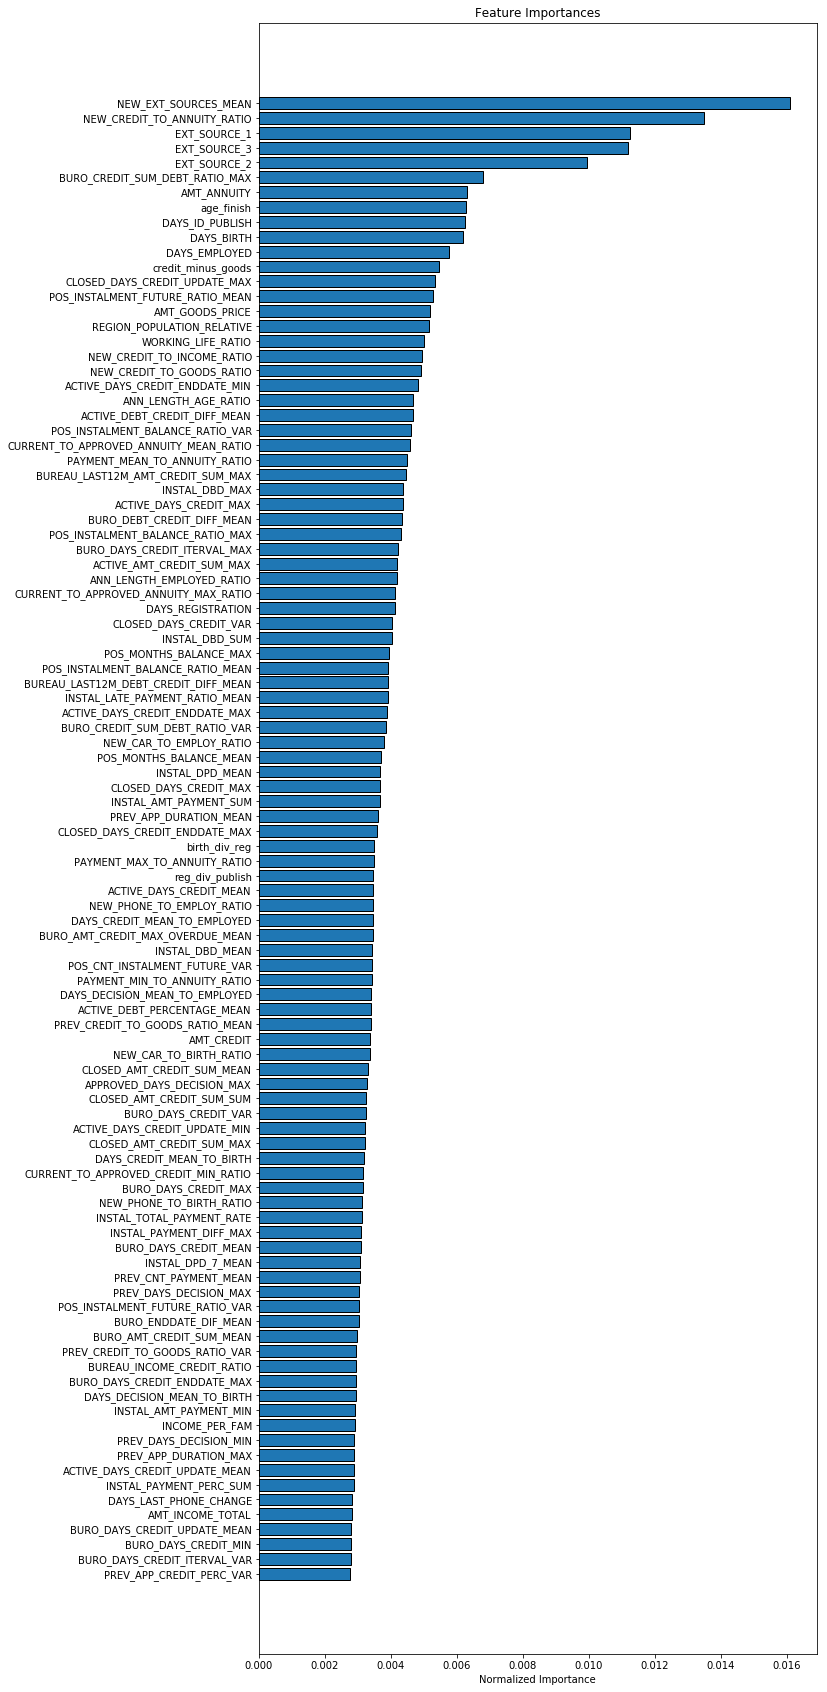

In [9]:
importlib.reload(modelling)
fi_sorted = modelling.plot_feature_importances(fi, 100)
# display(fi_sorted[fi_sorted["feature"]=="ORG_XNA_no_Pensioner"])
# with open("jjsmd.bin", "wb+") as f:
#     pickle.dump(fi, f)
# print(fi_sorted[fi_sorted["importance"]==0]["feature"].tolist()


In [10]:
oof_df = pd.DataFrame()
oof_df['SK_ID_CURR'] = app_train['SK_ID_CURR']
oof_df["LGB"] = oof
oof_df.to_csv("LGB_oof.csv")

In [ ]:
from eli5.permutation_importance import get_score_importances

def perm_score_func(X, y)：
    k_fold = KFold(n_splits=5, shuffle=True, random_state=50)
    feature_importance_values = np.zeros(len(feature_names))
    test_predictions = np.zeros(test.shape[0])
    out_of_fold = np.zeros(X.shape[0])

    valid_scores = []
    train_scores = []
    best_iteration = 2200
    for train_indices, valid_indices in k_fold.split(X):
        # Training data for the fold
        tnX, tny = X.loc[train_indices, :], y[train_indices]
        # Validation data for the fold
        vX, vy = X.loc[valid_indices, :], y[valid_indices]

        lgbm = LGBMClassifier(**lgbm_params)

        lgbm.fit(tnX, tny, eval_metric="auc", categorical_feature=cat_indices, feature_name='auto',
                 eval_set=[(vX, vy), (tnX, tny)], eval_names=['valid', 'train'],
                 early_stopping_rounds=400, verbose=200)
        test_predictions += lgbm.predict_proba(test, num_iteration=best_iteration)[:, 1] / k_fold.n_splits

        best_iteration = lgbm.best_iteration_
        feature_importance_values += lgbm.feature_importances_ / k_fold.n_splits
        out_of_fold[valid_indices] = lgbm.predict_proba(vX, num_iteration=best_iteration)[:, 1]

        valid_scores.append(lgbm.best_score_['valid']['auc'])
        train_scores.append(lgbm.best_score_['train']['auc'])

        gc.enable()
        del lgbm, tnX, vX
        gc.collect()
    valid_auc = roc_auc_score(y, out_of_fold)
    return valid_auc

y = app_train["TARGET"]
X = app_train.drop(["TARGET", 'SK_ID_CURR'], axis=1)

base_score, score_decreases = get_score_importances(perm_score_func, X, y)
feature_importances = np.mean(score_decreases, axis=0)